In [17]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import optuna
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [3]:
X = pd.read_csv('dataset/X_train.csv').set_index('DELIVERY_START')
X.index = pd.to_datetime(X.index, utc=True).tz_convert(None)
X.head()

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
DELIVERY_START,,,,,,,,,
2022-01-01 01:00:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.0,NaN
2022-01-01 02:00:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.0,NaN
2022-01-01 03:00:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.0,NaN
2022-01-01 04:00:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.0,NaN
2022-01-01 05:00:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.0,NaN


In [4]:
y = pd.read_csv('dataset/y_train.csv').set_index('DELIVERY_START')
y.index = pd.to_datetime(y.index, utc=True).tz_convert(None)

# fix outliers
y.loc["2022-04-04 05:00:00"] = (y.loc["2022-04-04 04:00:00"] + y.loc["2022-04-04 07:00:00"]) / 2
y.loc["2022-04-04 06:00:00"] = (y.loc["2022-04-04 04:00:00"] + y.loc["2022-04-04 07:00:00"]) / 2
y.head()

,spot_id_delta
DELIVERY_START,
2022-01-01 01:00:00,-36.874770
2022-01-01 02:00:00,-12.643588
2022-01-01 03:00:00,-1.950193
2022-01-01 04:00:00,1.938272
2022-01-01 05:00:00,0.199907


In [5]:
def create_time_features(df):
    df = df.copy()
    df['dayofmonth'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    return df

In [6]:
# initially try using all variables without preprocessing except 'load_forecast' and 'predicted_spot_price' (too many missing points)
X_cols = ['coal_power_available', 'gas_power_available',
       'nucelear_power_available', 'wind_power_forecasts_average',
       'solar_power_forecasts_average', 'wind_power_forecasts_std',
       'solar_power_forecasts_std']

In [7]:
X[X_cols].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10605 entries, 2022-01-01 01:00:00 to 2023-03-29 21:00:00
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   coal_power_available           10604 non-null  float64
 1   gas_power_available            10604 non-null  float64
 2   nucelear_power_available       10604 non-null  float64
 3   wind_power_forecasts_average   10581 non-null  float64
 4   solar_power_forecasts_average  10581 non-null  float64
 5   wind_power_forecasts_std       10581 non-null  float64
 6   solar_power_forecasts_std      10581 non-null  float64
dtypes: float64(7)
memory usage: 662.8 KB


In [8]:
X = X.interpolate()
X = create_time_features(X)

In [9]:
cutoff_date = "2023-03-01"
X_train = X.loc[:cutoff_date]
X_test = X.loc[cutoff_date:]
y_train = y.loc[:cutoff_date]
y_test = y.loc[cutoff_date:]


### train model

In [10]:
tscv = TimeSeriesSplit(n_splits=10, max_train_size=5000, test_size=500)

for train, test in tscv.split(X_train):
    print(f"[{train[0]}, ..., {train[-1]}] [{test[0]}, ..., {test[-1]}]")

[0, ..., 4934] [4935, ..., 5434]
[435, ..., 5434] [5435, ..., 5934]
[935, ..., 5934] [5935, ..., 6434]
[1435, ..., 6434] [6435, ..., 6934]
[1935, ..., 6934] [6935, ..., 7434]
[2435, ..., 7434] [7435, ..., 7934]
[2935, ..., 7934] [7935, ..., 8434]
[3435, ..., 8434] [8435, ..., 8934]
[3935, ..., 8934] [8935, ..., 9434]
[4435, ..., 9434] [9435, ..., 9934]


In [12]:
def objective(trial):
    tscv = TimeSeriesSplit(n_splits=10, max_train_size=5000, test_size=500)
    params = {
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1]),
        'num_leaves': trial.suggest_categorical('num_leaves', [5, 10, 20]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 7, 10]),
        'min_data_in_leaf': trial.suggest_categorical('min_data_in_leaf', [20, 30, 40]),
        'feature_fraction': trial.suggest_categorical('feature_fraction', [0.8, 0.9, 1.0]),
        'bagging_fraction': trial.suggest_categorical('bagging_fraction', [0.8, 0.9, 1.0]),
        'bagging_freq': trial.suggest_categorical('bagging_freq', [0, 5]),
        'lambda_l1': trial.suggest_categorical('lambda_l1', [0, 0.1, 0.5]),
        'lambda_l2': trial.suggest_categorical('lambda_l2', [0, 0.1, 0.5]),
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 500]),
        'verbose': -1
    }
    
    model = lgb.LGBMRegressor(**params)
    
    mse_arr = []
    for train_idx, test_idx in tscv.split(X_train):
        X_train_cv = X_train.iloc[train_idx]
        X_test_cv = X_train.iloc[test_idx]
        y_train_cv = y_train.iloc[train_idx]
        y_test_cv = y_train.iloc[test_idx]
    
        model.fit(X_train_cv, y_train_cv)
        pred = model.predict(X_test_cv)
        mse = mean_squared_error(y_test_cv, pred)
        mse_arr.append(mse)
        
    return np.mean(mse_arr)


In [13]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")

trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-10-28 23:52:55,065] A new study created in memory with name: no-name-48c3d2f7-2e68-41e9-9398-1ca9cc262328
[I 2024-10-28 23:52:56,656] Trial 0 finished with value: 1232.4476903783786 and parameters: {'learning_rate': 0.01, 'num_leaves': 10, 'max_depth': 5, 'min_data_in_leaf': 40, 'feature_fraction': 0.9, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'lambda_l1': 0.5, 'lambda_l2': 0.5, 'n_estimators': 100}. Best is trial 0 with value: 1232.4476903783786.
[I 2024-10-28 23:53:03,259] Trial 1 finished with value: 1224.9217975546949 and parameters: {'learning_rate': 0.01, 'num_leaves': 10, 'max_depth': 10, 'min_data_in_leaf': 30, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'lambda_l1': 0.5, 'lambda_l2': 0, 'n_estimators': 500}. Best is trial 1 with value: 1224.9217975546949.
[I 2024-10-28 23:53:04,049] Trial 2 finished with value: 1229.2610813271663 and parameters: {'learning_rate': 0.1, 'num_leaves': 5, 'max_depth': 10, 'min_data_in_leaf': 20, 'feature_fractio

Number of finished trials: 10
Best trial:
  Value: 1192.6398245646044
  Params: 
    learning_rate: 0.01
    num_leaves: 5
    max_depth: 5
    min_data_in_leaf: 20
    feature_fraction: 0.9
    bagging_fraction: 0.8
    bagging_freq: 0
    lambda_l1: 0.5
    lambda_l2: 0.1
    n_estimators: 200


### Test model with found hyperparams

In [15]:
model = lgb.LGBMRegressor(**trial.params)

In [16]:
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [28]:
results_df = y_test.copy()
results_df['pred'] = pred

<Axes: xlabel='DELIVERY_START'>

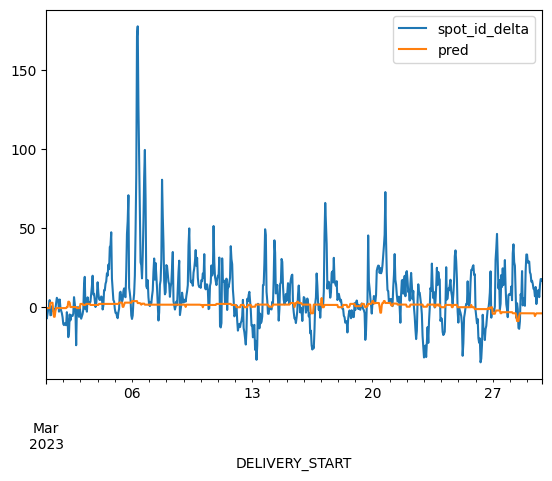

In [29]:
results_df.plot()